# Should you ever use a one-step forecaster?

In this notebook, I will show, how beneficial can be to use multiple forecast steps even if you want to forecast only one step ahead with neural networks. The models are built with Tensorflow. I used a simple model which has conv1d and LSTM layers. The forecasted time-series data is synthetic because I wanted to ensure that there exists a real pattern, but I tried to make it hard enough for the models to learn.

I compared the models' performance based only on the first forecast step. One model outputs only the next forecast step, the other model forecasts 10 steps, but we are interested only in the first step.

I found that the 10 step model is better to forecast the first step, than the other model which focused on the first step alone.

I used a sequence-to-sequence model. Aurélien Géron mentions in his book (Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow) that the advantage of seq-to-seq is that more error gradient will both stabilize and speed up training.

The idea of using more forecast steps than needed can be beneficial as well. It will result in slower training but can have a regularizer effect, especially in case of a time series with high variance. I checked only one time series and one model architecture so far, so I can't say that this can help in most cases, but in some cases, it can improve the forecast.

I didn't tun the hyperparameters. My goal wasn't to find the best possible model but to compare the performance of the 1 and 10 step forecast versions of the same architecture to see how it affects the model performance.

Codeparts are used from the Tensorflow site and from https://github.com/ageron.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
import importlib
import helper.series

In [2]:
# importlib.reload(helper.series)

In [5]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
matplotlib 3.0.3
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [6]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

## Dataset Builder

This function uses the tf.data.Dataset API to generate the datasets for the training, validation, and test. Because the model has a conv1d layer with "valid" padding, the sequence length changes during the computation. The "kernel_effect" parameter ensures that the output and label sequneces are compatible.

In [7]:
def timeseries_dataset(series, window_size, shift, batchsize, targetsize, kernel_effect=0):
    """
    From the original timeseries it generates the inputs for the network, and the labels.
    The labels lenght will be the target lenght of the forecast.
    Parameters:
      series: the input time series
      window_size: the lenght of the input
      shift: window shift along the series
      batchsize: batchsize
      targetsize: the size of the forecasted length
      kernel_effect: conv kernels can shorten the sequence, this parameter determines their effect
    Output: dataset of the input and label batches
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    stype = ds.element_spec.dtype
    ds = ds.window(window_size + targetsize, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + targetsize))
    if targetsize > 1:
        ds = ds.map(lambda window: (window[:-targetsize, np.newaxis], tf.map_fn(lambda i: window[i+1+kernel_effect:i+1+kernel_effect+targetsize], tf.range(window_size-kernel_effect), dtype=stype)))
    elif targetsize == 1:
        ds = ds.map(lambda window: (window[:-targetsize, np.newaxis], window[targetsize+kernel_effect:, np.newaxis]))
    elif targetsize == 0:
        ds = ds.map(lambda window: (window[:, np.newaxis], window[:, np.newaxis]))          
    return ds.batch(batchsize, drop_remainder=True)

## The Time Series

For us, it is easy to find patterns in the time series, but I added noise, jumps and shifted, non-equal length periods to make it harder to learn. You can examine the time series builder class in the helpre.series.py file.

In [8]:
time = np.arange(8 * 365)
builder = helper.series.SeriesBuilder(baseline=10, slope=0.05, period=365, amplitude=50, noise_level=2)
t_series = builder.generate_series(time)

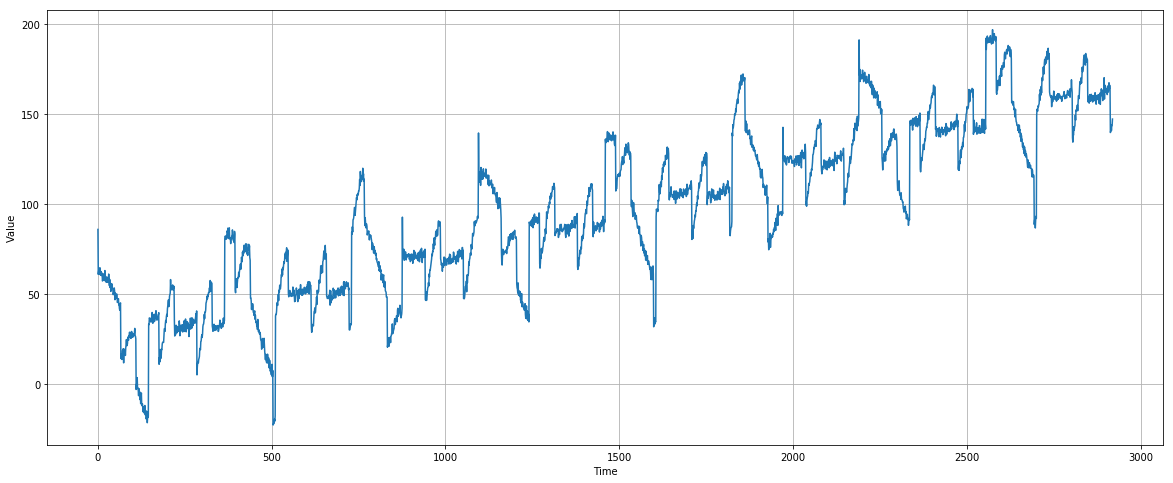

In [9]:
plt.figure(figsize=(20,8))
helper.series.plot_series(time, t_series)

In [10]:
# check output of the function
ds_demo = timeseries_dataset(time, window_size=3, shift=1, batchsize=2, targetsize=2, kernel_effect=1)
next(iter(ds_demo))

(<tf.Tensor: shape=(2, 3, 1), dtype=int64, numpy=
 array([[[0],
         [1],
         [2]],
 
        [[1],
         [2],
         [3]]])>, <tf.Tensor: shape=(2, 2, 2), dtype=int64, numpy=
 array([[[2, 3],
         [3, 4]],
 
        [[3, 4],
         [4, 5]]])>)

In [11]:
# split the time and timeseries to train and validation set
time_train = time[:365*6]
x_train = t_series[:365*6]
time_valid = time[365*6:365*7]
x_valid = t_series[365*6:365*7]
time_test = time[365*7:]
x_test = t_series[365*7:]

These datasets containe the inputs (X) and labels (Y) as well. The two model has different output length, so we need different datasets, as Y is different.

In [12]:
# build the training / validation dataset for the 1 and more target size
train_set_1 = timeseries_dataset(x_train, window_size=60, shift=1, batchsize=16, targetsize=1, kernel_effect=4) # kernel_effect of the simple_conv_and_lstm_layout
valid_set_1 = timeseries_dataset(x_valid, window_size=60, shift=1, batchsize=16, targetsize=1, kernel_effect=4)
test_set_1 = timeseries_dataset(x_test, window_size=60, shift=1, batchsize=16, targetsize=1, kernel_effect=4)

train_set_10 = timeseries_dataset(x_train, window_size=60, shift=1, batchsize=16, targetsize=10, kernel_effect=4)
valid_set_10 = timeseries_dataset(x_valid, window_size=60, shift=1, batchsize=16, targetsize=10, kernel_effect=4)
test_set_10 = timeseries_dataset(x_test, window_size=60, shift=1, batchsize=16, targetsize=10, kernel_effect=4)

## Network Layouts and Trainers

The "simple_conv_and_lstm_layout" functions defines the models. Only the "targetsize" parameter will differ, which will be one for the first, and 10 for the second model.

In [13]:
def simple_conv_and_lstm_layout(batchsize, window_size, targetsize):    
    """
    Define a simple LSTM layout
    """    
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=20, kernel_size=5, strides=1, padding="valid",
                            batch_input_shape=[batchsize, window_size, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(targetsize)),
        keras.layers.Lambda(lambda x: x * 200.0) # scale the outputs for faster learning
    ])
    return model

We will estimate the best learning rate from the learning rate / loss chart. Depending on the source the best starting learning is at the fastest rate of loss decrease, or at the largest learning rate, where the graph is smooth and decreasing. One source: https://medium.com/octavian-ai/how-to-use-the-learning-rate-finder-in-tensorflow-126210de9489

In [15]:
def learning_rate_finder(model, train_set):  
    """
    Goes trough learning rates and gives back the history object
    to find optimal learning rate.
    """
    # check learning rates to find the best
    lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    # get history to find the best learning rate
    return model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [4]:
def model_trainer(model, lr, train_set, valid_set, checkpoint_name):
    """
    Builds and traines simple lstm network.
    Returns the history object
    """
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9) # use best learning rate estimation
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    model_checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_name, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=50)
    return model.fit(train_set, epochs=5000,
            validation_data=valid_set,
            callbacks=[early_stopping, model_checkpoint])

## Model with target (output) size 1

In [17]:
model_lstm_ts1 = simple_conv_and_lstm_layout(batchsize=16, window_size = 60, targetsize=1)

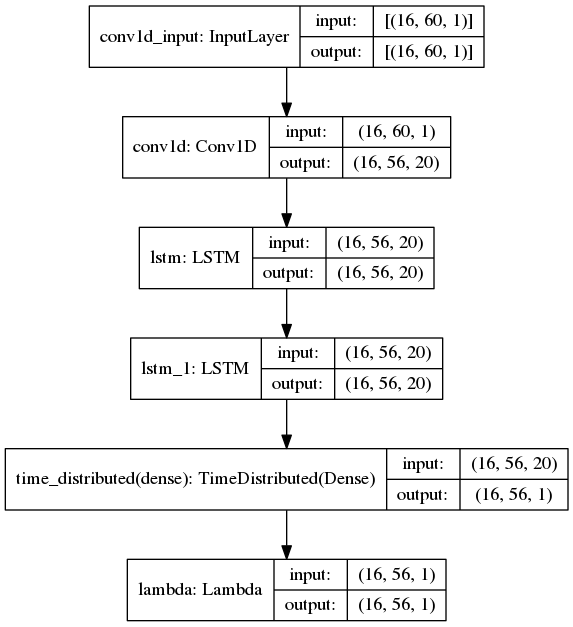

In [18]:
keras.utils.plot_model(model_lstm_ts1, "model.png", show_shapes=True)

Epoch 1/100
133/133 [==============================] - 9s 67ms/step - loss: 31.4194 - mae: 31.9156
Epoch 2/100
133/133 [==============================] - 3s 24ms/step - loss: 30.3390 - mae: 30.8346
Epoch 3/100
133/133 [==============================] - 3s 24ms/step - loss: 28.6875 - mae: 29.1834
Epoch 4/100
133/133 [==============================] - 3s 24ms/step - loss: 27.2583 - mae: 27.7536
Epoch 5/100
133/133 [==============================] - 3s 24ms/step - loss: 26.2706 - mae: 26.7662
Epoch 6/100
133/133 [==============================] - 3s 24ms/step - loss: 25.4424 - mae: 25.9376
Epoch 7/100
133/133 [==============================] - 3s 24ms/step - loss: 24.6863 - mae: 25.1811
Epoch 8/100
133/133 [==============================] - 3s 24ms/step - loss: 24.1667 - mae: 24.6618
Epoch 9/100
133/133 [==============================] - 3s 24ms/step - loss: 23.6240 - mae: 24.1196
Epoch 10/100
133/133 [==============================] - 3s 24ms/step - loss: 23.0448 - mae: 23.5398
Epoch 11/

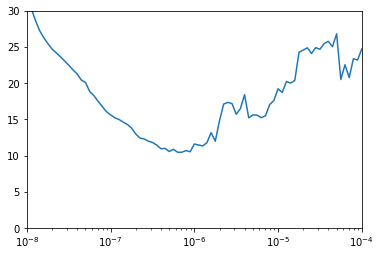

In [20]:
helper.series.lr_loss_chart(learning_rate_finder(model_lstm_ts1, train_set=train_set_1), 1e-8, 1e-4, 0, 30)

The performance of the 1 target model was really bad, so instead of using only one learning rate I tried three. Didn't help much.

In [23]:
# we see that lr around 2e-7 can be good, so train the network with that, but try out some other learning rates as well
lrs = [5e-8, 2e-7, 1e-6]
for lr in lrs:
    print("learning rate: {}".format(lr))
    model_lstm_ts1 = simple_conv_and_lstm_layout(batchsize=16, window_size = 60, targetsize=1)
    history_lstm_1 = model_trainer(model_lstm_ts1, lr = lr, train_set = train_set_1, valid_set = valid_set_1, checkpoint_name = "cp_lstm_1_{}.h5".format(lr))

learning rate: 5e-08
Epoch 1/5000
133/133 [==============================] - 12s 89ms/step - loss: 27.1041 - mae: 27.6006 - val_loss: 34.7853 - val_mae: 35.2838
Epoch 2/5000
133/133 [==============================] - 3s 26ms/step - loss: 29.0171 - mae: 29.5136 - val_loss: 35.4414 - val_mae: 35.9403
Epoch 3/5000
133/133 [==============================] - 3s 26ms/step - loss: 25.7453 - mae: 26.2404 - val_loss: 36.1598 - val_mae: 36.6585
Epoch 4/5000
133/133 [==============================] - 3s 25ms/step - loss: 24.0335 - mae: 24.5289 - val_loss: 36.0271 - val_mae: 36.5258
Epoch 5/5000
133/133 [==============================] - 3s 26ms/step - loss: 22.4521 - mae: 22.9466 - val_loss: 35.8956 - val_mae: 36.3944
Epoch 6/5000
133/133 [==============================] - 3s 26ms/step - loss: 21.6124 - mae: 22.1074 - val_loss: 35.4421 - val_mae: 35.9409
Epoch 7/5000
133/133 [==============================] - 3s 26ms/step - loss: 20.6488 - mae: 21.1435 - val_loss: 35.0999 - val_mae: 35.5988
Epoch

## Check the performance of the 1 target model

The one target model finished the training after some hundred epochs, didn't matter the learning rate. In the chart below we can see, that the forecasts (orange) were relatively far from the real series (blue), and the error (green) was most of the time positive.

In [25]:
model_lstm_ts1 = keras.models.load_model("cp_lstm_1_2e-07.h5")

(304, 56, 1)
(304,)


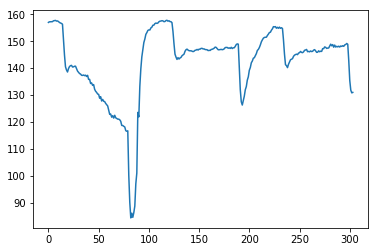

In [26]:
rnn_forecast = model_lstm_ts1.predict(test_set_1)
print(rnn_forecast.shape)
# in every step we only need the last output of the "return sequence"
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
print(rnn_forecast.shape)

plt.plot(rnn_forecast)

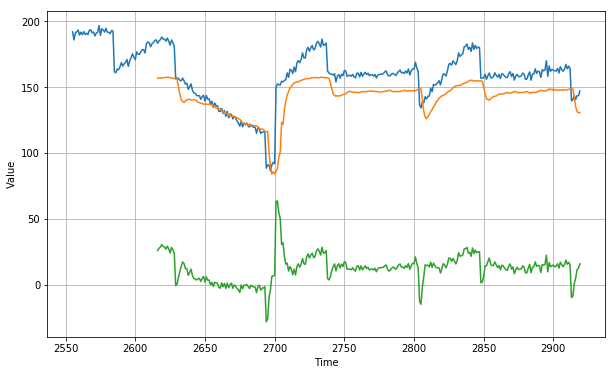

In [27]:
plt.figure(figsize=(10, 6))
helper.series.plot_series(time_test, x_test)
helper.series.plot_series(time_test[61:], rnn_forecast)
helper.series.plot_series(time_test[61:], x_test[61:] - rnn_forecast)

We compare the performance of the models based on the mean absolute error of the first forecast step.

In [28]:
keras.metrics.mean_absolute_error(x_test[61:], rnn_forecast).numpy()

14.036541

In [30]:
model_lstm_ts1 = keras.models.load_model("cp_lstm_1_5e-08.h5")
rnn_forecast = model_lstm_ts1.predict(test_set_1)
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
keras.metrics.mean_absolute_error(x_test[61:], rnn_forecast).numpy()

18.320343

In [31]:
model_lstm_ts1 = keras.models.load_model("cp_lstm_1_1e-06.h5")
rnn_forecast = model_lstm_ts1.predict(test_set_1)
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
keras.metrics.mean_absolute_error(x_test[61:], rnn_forecast).numpy()

12.229974

## Model with target (output) size 10

In [17]:
model_lstm_ts10 = simple_conv_and_lstm_layout(batchsize=16, window_size = 60, targetsize=10)

Epoch 1/100
132/132 [==============================] - 13s 100ms/step - loss: 80.8093 - mae: 81.3086
Epoch 2/100
132/132 [==============================] - 6s 45ms/step - loss: 79.7728 - mae: 80.2719
Epoch 3/100
132/132 [==============================] - 6s 45ms/step - loss: 78.7291 - mae: 79.2283
Epoch 4/100
132/132 [==============================] - 6s 44ms/step - loss: 77.7339 - mae: 78.2330
Epoch 5/100
132/132 [==============================] - 6s 45ms/step - loss: 76.7270 - mae: 77.2262
Epoch 6/100
132/132 [==============================] - 6s 46ms/step - loss: 75.2898 - mae: 75.7890
Epoch 7/100
132/132 [==============================] - 6s 49ms/step - loss: 74.1287 - mae: 74.6279
Epoch 8/100
132/132 [==============================] - 6s 46ms/step - loss: 73.6708 - mae: 74.1701
Epoch 9/100
132/132 [==============================] - 6s 45ms/step - loss: 73.0817 - mae: 73.5810
Epoch 10/100
132/132 [==============================] - 6s 45ms/step - loss: 72.4288 - mae: 72.9281
Epoch 1

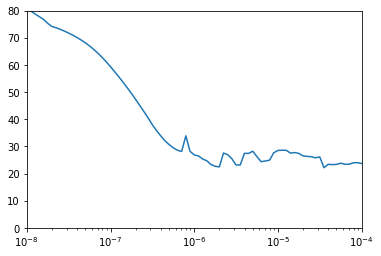

In [18]:
helper.series.lr_loss_chart(learning_rate_finder(model_lstm_ts10, train_set=train_set_10), 1e-8, 1e-4, 0, 80)

In [ ]:
# we see that lr around 5e-7 can be good, so train the network with that
model_lstm_ts10 = simple_conv_and_lstm_layout(batchsize=16, window_size = 60, targetsize=10)
history_lstm_10 = model_trainer(model_lstm_ts10, lr = 5e-7, train_set = train_set_10, valid_set = valid_set_10, checkpoint_name = "cp_lstm_10.h5")

Epoch 1/5000
132/132 [==============================] - 11s 80ms/step - loss: 71.1634 - mae: 71.6628 - val_loss: 121.9369 - val_mae: 122.4369
Epoch 2/5000
132/132 [==============================] - 7s 52ms/step - loss: 61.1302 - mae: 61.6291 - val_loss: 111.7039 - val_mae: 112.2038
Epoch 3/5000
132/132 [==============================] - 7s 52ms/step - loss: 52.4662 - mae: 52.9644 - val_loss: 102.5289 - val_mae: 103.0289
Epoch 4/5000
132/132 [==============================] - 7s 52ms/step - loss: 46.1660 - mae: 46.6637 - val_loss: 94.6698 - val_mae: 95.1698
Epoch 5/5000
132/132 [==============================] - 7s 51ms/step - loss: 40.7939 - mae: 41.2913 - val_loss: 86.2789 - val_mae: 86.7789
Epoch 6/5000
132/132 [==============================] - 7s 51ms/step - loss: 36.8063 - mae: 37.3035 - val_loss: 79.9827 - val_mae: 80.4827
Epoch 7/5000
132/132 [==============================] - 7s 52ms/step - loss: 34.1155 - mae: 34.6125 - val_loss: 74.9115 - val_mae: 75.4115
Epoch 8/5000
132/132

## Check the performance of the 10 target model

It was a very long training and the notebook on Google AI platform became irresponsive. Fortunately the best parameters were saved during training. Instead of burning more credit for training, I just loaded back the last best. This 10-target model performed far better than the 1-target model, and it can be improved further. 

With this time series and with this model layout increasing the target size from 1 to 10 dramatically improved the performance of the first step forecast.

According to this result, it can be a good idea to forecast for more time steps than needed, or compare different target lengths for the common forecast steps.

In [17]:
model_lstm_ts10 = keras.models.load_model("cp_lstm_10.h5")

(288, 56, 10)
(288,)


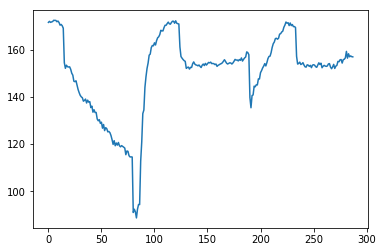

In [18]:
rnn_forecast = model_lstm_ts10.predict(test_set_10)
print(rnn_forecast.shape)
# in every step we only need the last output of the "return sequence"
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
print(rnn_forecast.shape)

plt.plot(rnn_forecast)

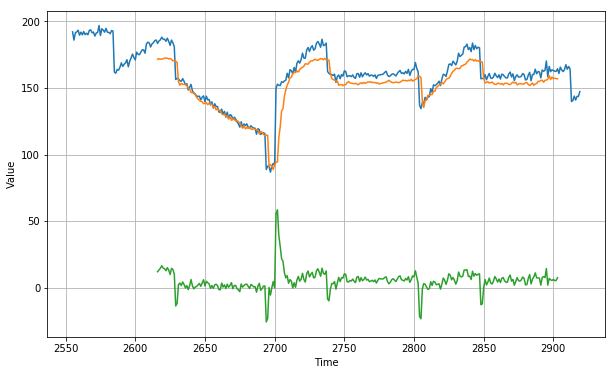

In [21]:
plt.figure(figsize=(10, 6))
helper.series.plot_series(time_test, x_test)
helper.series.plot_series(time_test[61:-16], rnn_forecast)
helper.series.plot_series(time_test[61:-16], x_test[61:-16] - rnn_forecast)

MAE is only 6.6. It was 12-18 with the 1-target model.

In [23]:
keras.metrics.mean_absolute_error(x_test[61:-16], rnn_forecast).numpy()

6.633674